# Sales Prediction using machine learning
## Task at CodeClause
* Done By Aashish karn

This is a `time series` analysis where we have used the day to day data for the prediciton of the upcomming days.  

### Importing Important Libraries

In [120]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
#loading data

def load_data(data):
    return pd.read_csv(data)

sale_data =  load_data("sales.csv")
 
sale_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
sale_data.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [14]:
sale_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


There are no null data in sales so we can proceed with the further works.

### Visualising Dataset property

<AxesSubplot:>

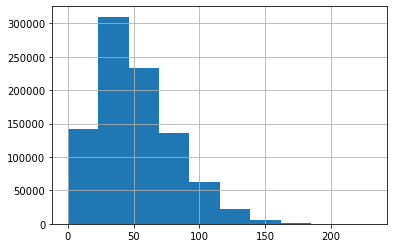

In [12]:
sale_data.sales.hist()

we are going to work with `sales` column so let's drop store and item column.

In [45]:
sale_data = sale_data.drop(['store' , 'item'] , axis = 1)

For the convinent use of Data and time we have to convert it into date time type

In [46]:
sale_data.date = pd.to_datetime(sale_data.date)

In [47]:
sale_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [50]:
#again Let's convert date to a month period
#find the sales for the each month

sale_data.date = sale_data.date.dt.to_period("m")


In [150]:
monthly_sale = sale_data.groupby('date').sum().reset_index()



monthly_sale.date =  monthly_sale.date.dt.to_timestamp()

monthly_sale.head()


,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


### Since the data is in `increasing` order we can also visualise in graph for making data `stationary` we'll take        difference of data consequtively

Text(0.5, 1.0, 'Montly sales Normally')

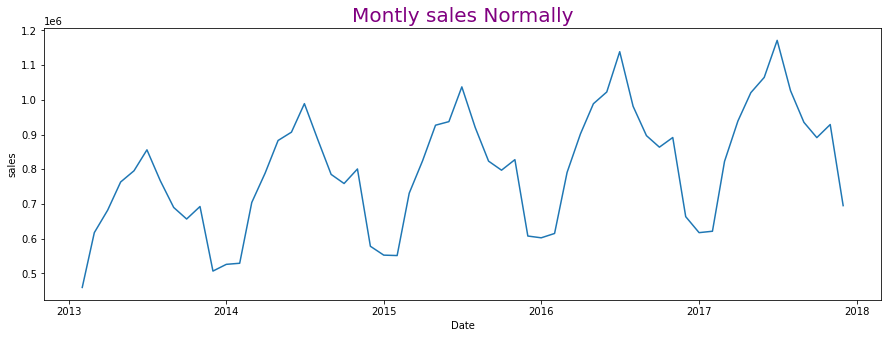

In [151]:

monthly_sale['sales_diff'] = monthly_sale['sales'].diff()
monthly_sale = monthly_sale.dropna()


plt.figure(figsize = (15 ,5))
plt.plot(monthly_sale.date , monthly_sale.sales)
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly sales Normally" , color = "purple" , fontsize =  20)

Text(0.5, 1.0, 'Montly sales when stationary')

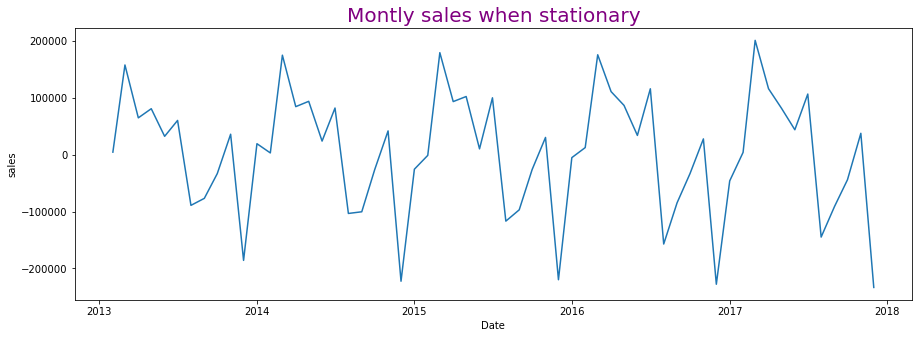

In [142]:
plt.figure(figsize = (15 ,5))
plt.plot(monthly_sale.date , monthly_sale.sales_diff)
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly sales when stationary" , color = "purple" , fontsize =  20)

We have finally made our data stationary by finding difference and it became stationary because it has the increasing trend earlier

In [174]:
Final_data = monthly_sale.drop(['date','sales'], axis=1)
Final_data

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0
6,60325.0
7,-89161.0
8,-76854.0
9,-33320.0
10,36056.0


We need to predict the 13th month sale from the use of the previous 12 month sale so splitting data in similar way.

Using following logic

In [175]:
for i in range(1,13):
    #we put the column name from 1 to 12 i,e month_1 , month_2 etc
    column_name = 'month_' + str(i)
    
    #shift is most importat thing here below is the explanation
    Final_data[column_name] = Final_data['sales_diff'].shift(i)
Final_data = Final_data.dropna().reset_index(drop=True)

In [177]:
Final_data.head()

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


### Pandas dataframe.shift() function Shift index by desired number of periods with an optional time freq. This function takes a `scalar parameter` called the period, which represents the number of shifts to be made over the desired axis. This function is very helpful when dealing with time-series data. 

For more explanation visit to https://www.geeksforgeeks.org/python-pandas-dataframe-shift/


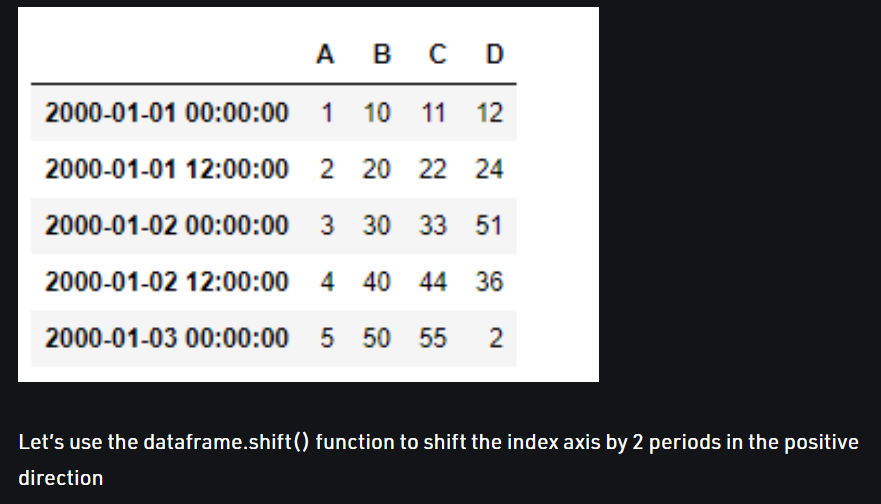

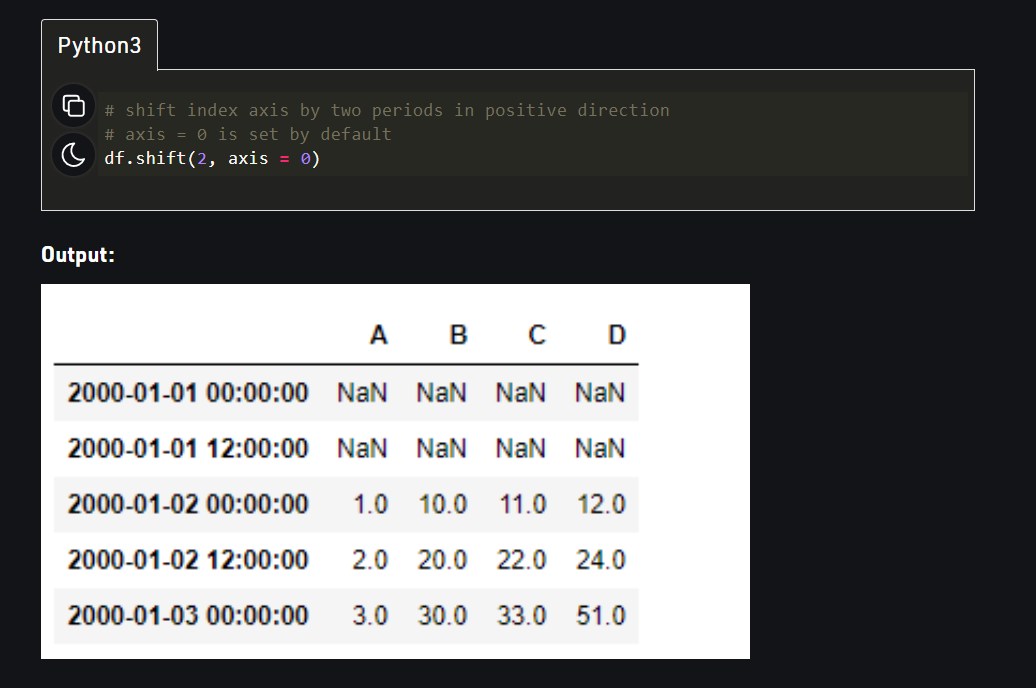

In [161]:
### Splotting train test data set

train_data = Final_data[:-12]
test_data = Final_data[-12:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [127]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [129]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (35, 12)
y_train Shape: (35,)
X_test Shape: (12, 12)
y_test Shape: (12,)


In [130]:
sales_dates = monthly_sale['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [131]:
act_sales = monthly_sale['sales'][-13:].to_list()

In [132]:


linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_pred = linreg_model.predict(X_test)


In [133]:
linreg_pred = linreg_pred.reshape(-1,1)
linreg_pred_test_set = np.concatenate([linreg_pred,X_test], axis=1)
linreg_pred_test_set = scaler.inverse_transform(linreg_pred_test_set)

In [134]:
result_list = []
for index in range(0, len(linreg_pred_test_set)):
    result_list.append(linreg_pred_test_set[index][0] + act_sales[index])
linreg_pred_series = pd.Series(result_list,name='linreg_pred')
predict_df = predict_df.merge(linreg_pred_series, left_index=True, right_index=True)


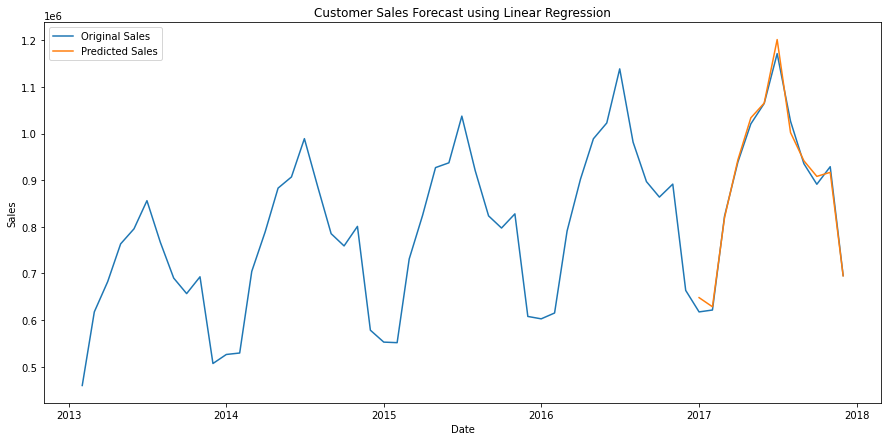

In [136]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sale['date'], monthly_sale['sales'])
plt.plot(predict_df['date'], predict_df['linreg_pred'])
plt.title("Customer Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()